# CMRM Homework Assignment No. 2 (HWA2)

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

## Question 1

In [2]:
def compute_chromagram(x, Fs, chroma_type='stft', print_chromagram=True):
    """Compute the chromagram according to the chroma_type
    
    Args:
        x: input audio file .wav
        Fs: sampling frequency
        chroma_type: type of the chromagram (default='stft')
        print_chromagram: if True, print chromagram (default=True)
    Return:
        chromagram: computed chromagram
    """
    
    # Compute the chromagram
    
    if chroma_type == 'stft':
        chromagram = librosa.feature.chroma_stft(y = x, sr = Fs)
    elif chroma_type == 'cqt':
        chromagram = librosa.feature.chroma_cqt(y = x, sr = Fs)

    # Plot the chromagram
    if print_chromagram:
        
        fig = plt.figure(figsize=(12, 4))
        librosa.display.specshow(chromagram)
        plt.title('Chromagram ' + chroma_type)
        plt.xlabel('Time')
        plt.ylabel('Chroma')
        plt.colorbar()
        plt.tight_layout()
    
    return chromagram

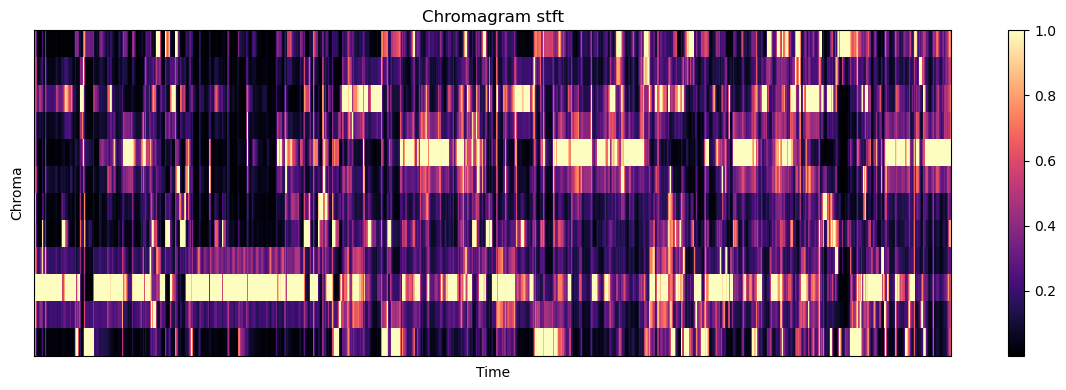

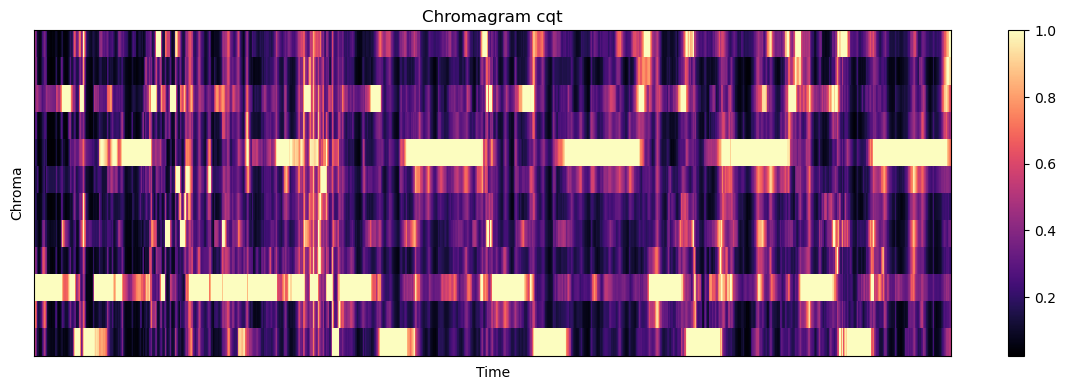

In [3]:
# Test the function here

fn_wav = os.path.join('data', 'audio', 'LynyrdSkynyrd_SweetHomeAlabama.wav')
x, Fs = librosa.load(fn_wav)

chromagram_stft = compute_chromagram(x, Fs, 'stft', True)
chromagram_cqt = compute_chromagram(x, Fs, 'cqt', True)

## Question 2

In [4]:
# Define chroma labels and keys

ground_truth = os.path.join('data', 'ground_truth.xlsx')
truth = pd.read_excel(ground_truth, index_col=0)
print('The key associated to the song is', truth.at['Lynyrd Skynyrd', 'Key'])

# Define a list chroma_labels containing all the chromas

chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Define a new list keys containing all the names for the considered scales,
# adding to the chromas the words major or minor

keys_maj = [s + ' major' for s in chroma_labels]
keys_min = [s + ' minor' for s in chroma_labels]
keys = keys_maj + keys_min

# Compute prominance

prominance = np.zeros(12)
    
chroma_vals = []

(a, b) = chromagram_stft.shape

for c in range(12):

    for n in range(b):
        prominance[c] += chromagram_stft[c, n]

    chroma_vals.append(prominance[c])

print('\nProminance =', prominance)
print('\nChroma_vals =', chroma_vals)

# Define a dictionary associating prominance to each key

key_vals = {}

for i in range(len(chroma_labels)):
    key_vals[chroma_labels[i]] = chroma_vals[i]
        
print('\nKey_vals =', key_vals)

The key associated to the song is G major

Prominance = [349.36991935 384.490191   833.05237712 349.84374216 347.70374863
 256.83687173 358.40128146 572.09555066 336.11971268 471.60343759
 260.93531375 364.23969198]

Chroma_vals = [349.3699193454813, 384.49019100284204, 833.0523771194275, 349.8437421610579, 347.70374863315374, 256.8368717280682, 358.40128146251664, 572.0955506647006, 336.11971267545596, 471.6034375920426, 260.93531375494786, 364.2396919839084]

Key_vals = {'C': 349.3699193454813, 'C#': 384.49019100284204, 'D': 833.0523771194275, 'D#': 349.8437421610579, 'E': 347.70374863315374, 'F': 256.8368717280682, 'F#': 358.40128146251664, 'G': 572.0955506647006, 'G#': 336.11971267545596, 'A': 471.6034375920426, 'A#': 260.93531375494786, 'B': 364.2396919839084}


## Question 3

In [5]:
# Define binary key profiles

template_cmaj = np.array([[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]).T
template_cmin = np.array([[1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]]).T

templates = np.concatenate((template_cmaj, template_cmin), axis=1)

template_matrix = np.zeros((12, 12 * templates.shape[1]))

for shift in range(12):
    #np.roll: roll array elements along a given axis.
    template_matrix[:, shift::12] = np.roll(templates, shift, axis=0)

# Define perceptual key profiles

template_cmaj_perceptual = np.array([[6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]]).T
template_cmin_perceptual = np.array([[6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]]).T

templates = np.concatenate((template_cmaj_perceptual, template_cmin_perceptual), axis=1)

template_matrix_perceptual = np.zeros((12, 12 * templates.shape[1]))

for shift in range(12):
    #np.roll: roll array elements along a given axis.
    template_matrix_perceptual[:, shift::12] = np.roll(templates, shift, axis=0)

print('The ground-truth is', truth.at['Lynyrd Skynyrd', 'Key'])

# BINARY PROFILES

# Compute Pearson correlation coefficients 

pearson_coef = np.zeros(24)

for i in range(24):
    
    pearson_coef[i] = np.corrcoef(chroma_vals[:], template_matrix[:, i])[0][1]

# Define a dictionary associating keys to the correlation coefficients

key_dict = {}

for i in range(len(keys)):
    key_dict[keys[i]] = pearson_coef[i]

# Compute the most likely key

best_key = max(key_dict, key=key_dict.get)
best_corr = key_dict[best_key]

print('\nBinary profiles')
print('\nBest_key =', best_key, 'Best_corr =', best_corr)

# PERCEPTUAL PROFILES

pearson_coef_perceptual = np.zeros(24)

for i in range(24):
    
    pearson_coef_perceptual[i] = np.corrcoef(chroma_vals[:], template_matrix_perceptual[:, i])[0][1]

# Define a dictionary associating keys to the correlation coefficients

key_dict_perceptual = {}

for i in range(len(keys)):
    key_dict_perceptual[keys[i]] = pearson_coef_perceptual[i]

# Compute the most likely key

best_corr_perceptual = max(pearson_coef_perceptual)
best_key_perceptual = keys[[index for index, item in enumerate(pearson_coef_perceptual) if item == best_corr_perceptual][0]]

print('\nPerceptual profiles')
print('\nBest_key =', best_key_perceptual, 'Best_corr =', best_corr_perceptual)

The ground-truth is G major

Binary profiles

Best_key = D major Best_corr = 0.536778720611013

Perceptual profiles

Best_key = D major Best_corr = 0.8411781270832607


## Question 4

In [6]:
def detect_key(C, maj_profile, min_profile, verbose=False):
    """Compute an estimate of the musical key given a chromagram
    
    Args:
        C: chromagram
        maj_profile: profile for major scales 
        min_profile: profile for minor scales  
        verbose: if True, print prominance of chromas and correlation coefficients (default=False)     
    Returns:
        best_key: best estimate of musical key
        best_corr: correlation coefficient of best_key
        alt_key: alternative estimate of musical key 
        alt_best_corr: correlation coefficient of alt_best_corr
    """

    # Compute the prominance of each chroma in the song
    
    prominance = np.zeros(12)

    chroma_vals = []

    (a, m) = C.shape

    for c in range(12):

        for n in range(m):
            prominance[c] += C[c, n]

        chroma_vals.append(prominance[c])

    # Define the 12 chroma labels in a list
    
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # Define the 24 key names in a dictionary
    
    keys_maj = [s + ' major' for s in chroma_labels]
    keys_min = [s + ' minor' for s in chroma_labels]
    keys = keys_maj + keys_min
    
    key_vals = {}

    for i in range(len(chroma_labels)):
        key_vals[chroma_labels[i]] = chroma_vals[i]
        
    templates = np.concatenate((maj_profile, min_profile), axis=1)

    template_matrix = np.zeros((12, 12 * templates.shape[1]))

    for shift in range(12):
        #np.roll: roll array elements along a given axis.
        template_matrix[:, shift::12] = np.roll(templates, shift, axis=0)
    
    # Compute the Pearons correlation coefficient between the key profiles
    # and the prominance of each chroma
    
    pearson_coef = np.zeros(24)

    for i in range(24):

        pearson_coef[i] = np.corrcoef(chroma_vals[:], template_matrix[:, i])[0][1]
        
    # Define a new dictionary associating all the correlation coefficients to the keys
    
    key_dict = {}

    for i in range(len(keys)):
        key_dict[keys[i]] = pearson_coef[i]
     
    # Compute the most likely key
    
    best_key = max(key_dict, key=key_dict.get)
    best_corr = key_dict[best_key]
   
    # Compute the second best key
    
    del key_dict[best_key]
    
    alt_key = max(key_dict, key = key_dict.get)
    alt_best_corr = key_dict[alt_key]
    
    if alt_best_corr < 0.75*best_corr:
        alt_best_corr = None
        alt_key = None

    if verbose:
        
        # Print the prominence of chromas 
        
        print('Prominance =', prominance)

        # Print the correlation coefficients associated with each major/minor key
        
        print('\nKey_dict =', key_dict)

    return best_key, best_corr, alt_key, alt_best_corr 

In [7]:
# Test the function here

best_key, best_corr, alt_key, alt_best_corr = detect_key(chromagram_stft, template_cmaj_perceptual, template_cmin_perceptual, True)

print('\n\nThe ground-truth is', truth.at['Lynyrd Skynyrd', 'Key'])
print('\nBest_key = ', best_key, 'Best_corr =', best_corr)
print('\nAlt_key = ', alt_key, 'Alt_best_corr =', alt_best_corr)

Prominance = [349.36991935 384.490191   833.05237712 349.84374216 347.70374863
 256.83687173 358.40128146 572.09555066 336.11971268 471.60343759
 260.93531375 364.23969198]

Key_dict = {'C major': 0.17415900492955746, 'C# major': -0.42785455857336785, 'D# major': -0.18817212451667303, 'E major': -0.2361760828467029, 'F major': -0.07488284337004562, 'F# major': -0.3801303563041988, 'G major': 0.7240427420839346, 'G# major': -0.3523651228066919, 'A major': 0.2730225992687467, 'A# major': -0.027315944180053196, 'B major': -0.3255054407677663, 'C minor': 0.00442089885904014, 'C# minor': -0.22051472436266242, 'D minor': 0.5453438978939469, 'D# minor': -0.3391913551634141, 'E minor': 0.17028767344536924, 'F minor': -0.444741347619572, 'F# minor': 0.14929897602540193, 'G minor': 0.42932669562023057, 'G# minor': -0.34205455877533525, 'A minor': 0.08140463948925487, 'A# minor': -0.5250368616538095, 'B minor': 0.4914560662415493}


The ground-truth is G major

Best_key =  D major Best_corr = 0.8

## Question 5

### Lynyrd Skynyrd - Sweet Home Alabama


The ground-truth is G major


BINARY PROFILES:

stft
Best_key = D major Best_corr = 0.536778720611013
Alt_key = B minor Alt_best_corr = 0.536778720611013

cqt
Best_key = G major Best_corr = 0.694018917138804
Alt_key = E minor Alt_best_corr = 0.694018917138804


PERCEPTUAL PROFILES:

stft
Best_key = D major Best_corr = 0.8411781270832607
Alt_key = G major Alt_best_corr = 0.7240427420839346

cqt
Best_key = G major Best_corr = 0.9095034927689418
Alt_key = D major Alt_best_corr = 0.7870694692890533


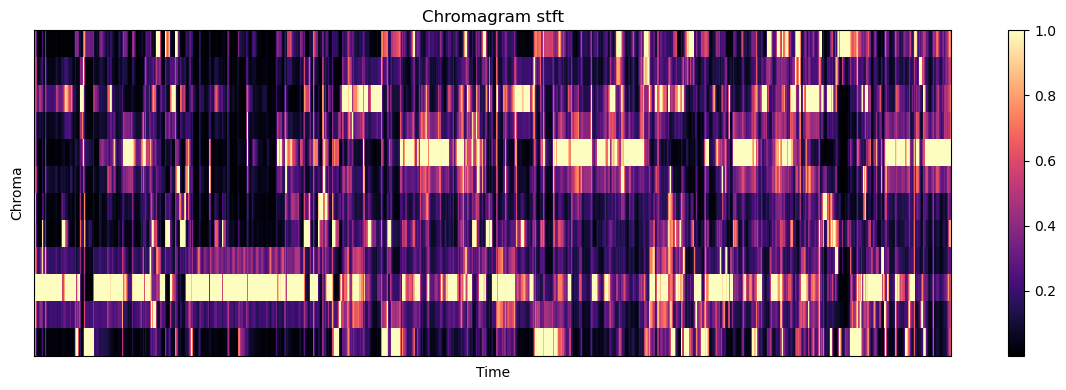

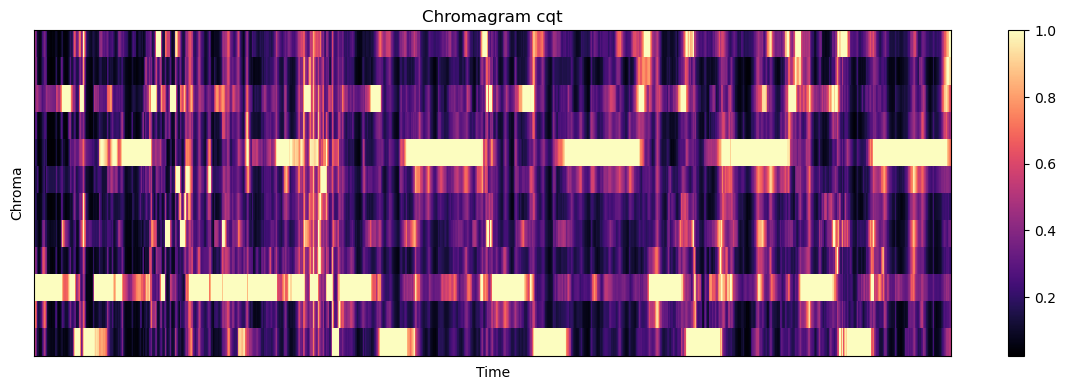

In [8]:
# Load audio file

fn_wav = os.path.join('data', 'audio', 'LynyrdSkynyrd_SweetHomeAlabama.wav')
x, Fs = librosa.load(fn_wav)

# Load .csv file

ground_truth = os.path.join('data', 'ground_truth.xlsx')
truth = pd.read_excel(ground_truth, index_col=0)

# Print ground-truth key

print('\nThe ground-truth is', truth.at['Lynyrd Skynyrd', 'Key'])

# Binary profiles for major and minor scales

template_cmaj = np.array([[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]).T
template_cmin = np.array([[1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]]).T

# Perceptual profiles for major and minor scales

template_cmaj_perceptual = np.array([[6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]]).T
template_cmin_perceptual = np.array([[6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]]).T

# Compute chromagram

C = compute_chromagram(x, Fs, 'stft', True)

# Detect key

best_key_stft, best_corr_stft, alt_key_stft, alt_best_corr_stft = detect_key(C, template_cmaj, template_cmin, False)
best_key_stft_perceptual, best_corr_stft_perceptual, alt_key_stft_perceptual, alt_best_corr_stft_perceptual = detect_key(C, template_cmaj_perceptual, template_cmin_perceptual, False)

# Same thing for chroma_cqt
C = compute_chromagram(x, Fs, 'cqt', True)

best_key_cqt, best_corr_cqt, alt_key_cqt, alt_best_corr_cqt = detect_key(C, template_cmaj, template_cmin, False)
best_key_cqt_perceptual, best_corr_cqt_perceptual, alt_key_cqt_perceptual, alt_best_corr_cqt_perceptual = detect_key(C, template_cmaj_perceptual, template_cmin_perceptual, False)

# Print the key determined by the algorithm and the best alternative
print('\n\nBINARY PROFILES:')
print('\nstft')
print('Best_key =', best_key_stft, 'Best_corr =', best_corr_stft)
print('Alt_key =', alt_key_stft, 'Alt_best_corr =', alt_best_corr_stft)
print('\ncqt')
print('Best_key =', best_key_cqt, 'Best_corr =', best_corr_cqt)
print('Alt_key =', alt_key_cqt, 'Alt_best_corr =', alt_best_corr_cqt)

print('\n\nPERCEPTUAL PROFILES:')
print('\nstft')
print('Best_key =', best_key_stft_perceptual, 'Best_corr =', best_corr_stft_perceptual)
print('Alt_key =', alt_key_stft_perceptual, 'Alt_best_corr =', alt_best_corr_stft_perceptual)
print('\ncqt')
print('Best_key =', best_key_cqt_perceptual, 'Best_corr =', best_corr_cqt_perceptual)
print('Alt_key =', alt_key_cqt_perceptual, 'Alt_best_corr =', alt_best_corr_cqt_perceptual)

### Beatles - Here Comes the Sun


The ground-truth is A major


BINARY PROFILES:

stft
Best_key = E major Best_corr = 0.6281309225211252
Alt_key = C# minor Alt_best_corr = 0.6281309225211252

cqt
Best_key = A major Best_corr = 0.4289488841610784
Alt_key = F# minor Alt_best_corr = 0.4289488841610784


PERCEPTUAL PROFILES:

stft
Best_key = A major Best_corr = 0.7933569856574775
Alt_key = E major Alt_best_corr = 0.68406285765354

cqt
Best_key = A major Best_corr = 0.8239873368525159
Alt_key = None Alt_best_corr = None


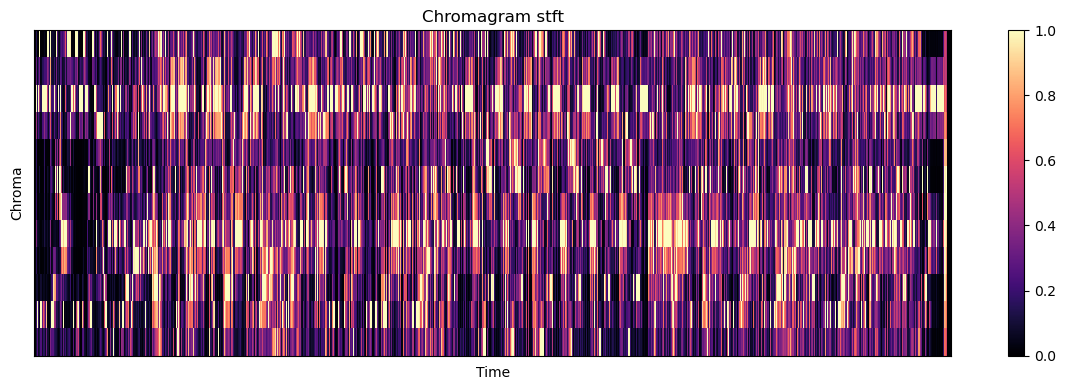

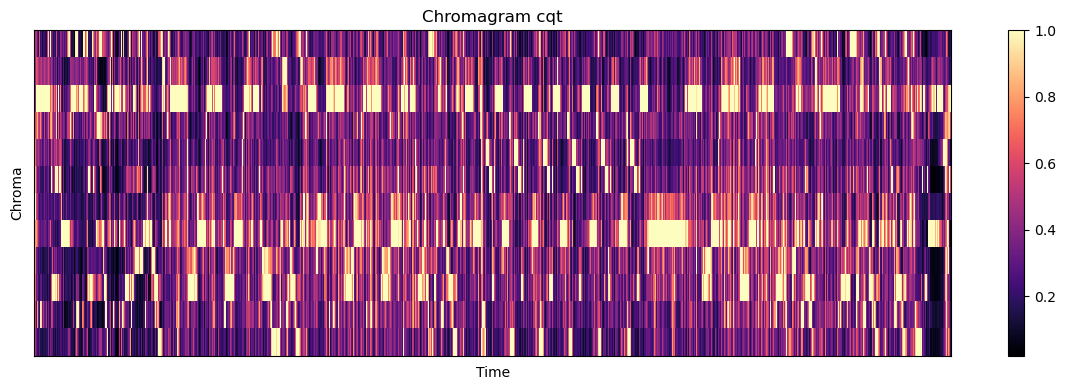

In [9]:
# Load audio file

fn_wav = os.path.join('data', 'audio', 'Beatles_HereComesTheSun.wav')
x, Fs = librosa.load(fn_wav)

# Load .csv file

ground_truth = os.path.join('data', 'ground_truth.xlsx')
truth = pd.read_excel(ground_truth, index_col=0)

# Print ground-truth key

print('\nThe ground-truth is', truth.at['Beatles', 'Key'])

# Binary profiles for major and minor scales

template_cmaj = np.array([[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]).T
template_cmin = np.array([[1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]]).T

# Perceptual profiles for major and minor scales

template_cmaj_perceptual = np.array([[6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]]).T
template_cmin_perceptual = np.array([[6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]]).T

# Compute chromagram

C = compute_chromagram(x, Fs, 'stft', True)

# Detect key

best_key_stft, best_corr_stft, alt_key_stft, alt_best_corr_stft = detect_key(C, template_cmaj, template_cmin, False)
best_key_stft_perceptual, best_corr_stft_perceptual, alt_key_stft_perceptual, alt_best_corr_stft_perceptual = detect_key(C, template_cmaj_perceptual, template_cmin_perceptual, False)

# Same thing for chroma_cqt
C = compute_chromagram(x, Fs, 'cqt', True)

best_key_cqt, best_corr_cqt, alt_key_cqt, alt_best_corr_cqt = detect_key(C, template_cmaj, template_cmin, False)
best_key_cqt_perceptual, best_corr_cqt_perceptual, alt_key_cqt_perceptual, alt_best_corr_cqt_perceptual = detect_key(C, template_cmaj_perceptual, template_cmin_perceptual, False)

# Print the key determined by the algorithm and the best alternative
print('\n\nBINARY PROFILES:')
print('\nstft')
print('Best_key =', best_key_stft, 'Best_corr =', best_corr_stft)
print('Alt_key =', alt_key_stft, 'Alt_best_corr =', alt_best_corr_stft)
print('\ncqt')
print('Best_key =', best_key_cqt, 'Best_corr =', best_corr_cqt)
print('Alt_key =', alt_key_cqt, 'Alt_best_corr =', alt_best_corr_cqt)

print('\n\nPERCEPTUAL PROFILES:')
print('\nstft')
print('Best_key =', best_key_stft_perceptual, 'Best_corr =', best_corr_stft_perceptual)
print('Alt_key =', alt_key_stft_perceptual, 'Alt_best_corr =', alt_best_corr_stft_perceptual)
print('\ncqt')
print('Best_key =', best_key_cqt_perceptual, 'Best_corr =', best_corr_cqt_perceptual)
print('Alt_key =', alt_key_cqt_perceptual, 'Alt_best_corr =', alt_best_corr_cqt_perceptual)

### Antonio Vivaldi - Allegro non molto from RV 297


The ground-truth is F minor


BINARY PROFILES:

stft
Best_key = G# major Best_corr = 0.6497194540193666
Alt_key = F minor Alt_best_corr = 0.6497194540193666

cqt
Best_key = G# major Best_corr = 0.7480114723518584
Alt_key = F minor Alt_best_corr = 0.7480114723518584


PERCEPTUAL PROFILES:

stft
Best_key = F minor Best_corr = 0.7693289169186719
Alt_key = C major Alt_best_corr = 0.6310896425350773

cqt
Best_key = F minor Best_corr = 0.7924041722926536
Alt_key = G# major Alt_best_corr = 0.6126148282840351


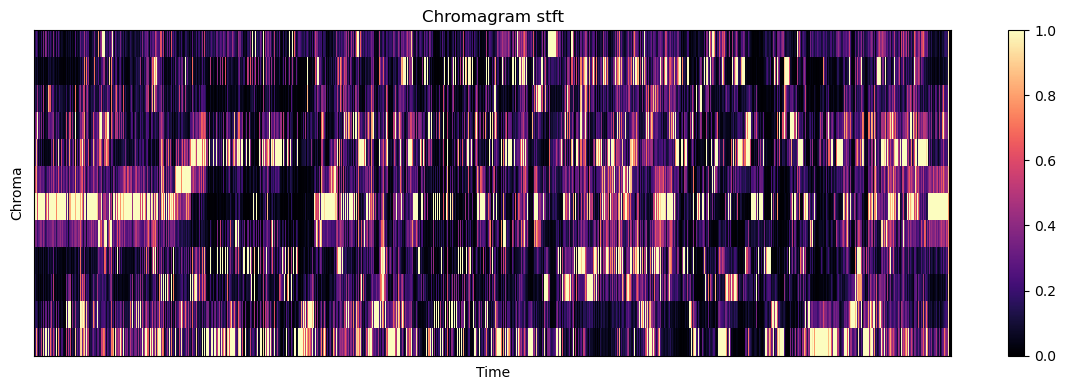

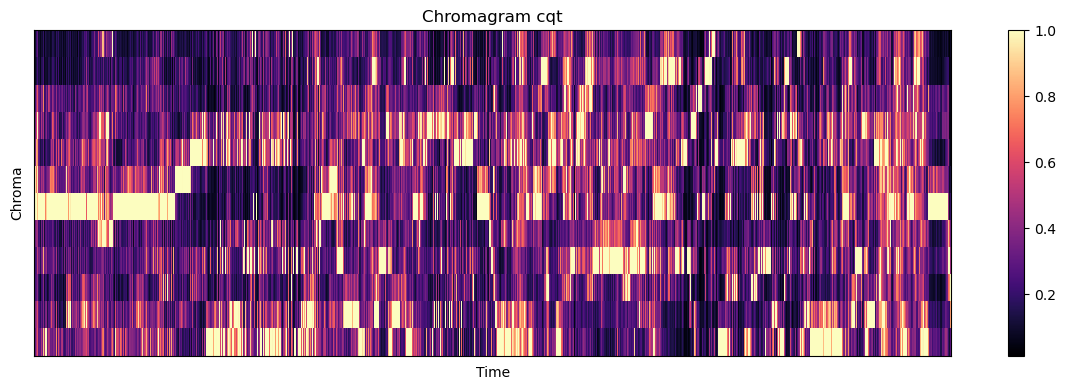

In [10]:
# Load audio file

fn_wav = os.path.join('data', 'audio', 'Vivaldi_AllegroNonMoltoRV297.wav')
x, Fs = librosa.load(fn_wav)

# Load .csv file

ground_truth = os.path.join('data', 'ground_truth.xlsx')
truth = pd.read_excel(ground_truth, index_col=0)

# Print ground-truth key

print('\nThe ground-truth is', truth.at['Antonio Vivaldi', 'Key'])

# Binary profiles for major and minor scales

template_cmaj = np.array([[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]).T
template_cmin = np.array([[1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]]).T

# Perceptual profiles for major and minor scales

template_cmaj_perceptual = np.array([[6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]]).T
template_cmin_perceptual = np.array([[6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]]).T

# Compute chromagram

C = compute_chromagram(x, Fs, 'stft', True)

# Detect key

best_key_stft, best_corr_stft, alt_key_stft, alt_best_corr_stft = detect_key(C, template_cmaj, template_cmin, False)
best_key_stft_perceptual, best_corr_stft_perceptual, alt_key_stft_perceptual, alt_best_corr_stft_perceptual = detect_key(C, template_cmaj_perceptual, template_cmin_perceptual, False)

# Same thing for chroma_cqt
C = compute_chromagram(x, Fs, 'cqt', True)

best_key_cqt, best_corr_cqt, alt_key_cqt, alt_best_corr_cqt = detect_key(C, template_cmaj, template_cmin, False)
best_key_cqt_perceptual, best_corr_cqt_perceptual, alt_key_cqt_perceptual, alt_best_corr_cqt_perceptual = detect_key(C, template_cmaj_perceptual, template_cmin_perceptual, False)

# Print the key determined by the algorithm and the best alternative
print('\n\nBINARY PROFILES:')
print('\nstft')
print('Best_key =', best_key_stft, 'Best_corr =', best_corr_stft)
print('Alt_key =', alt_key_stft, 'Alt_best_corr =', alt_best_corr_stft)
print('\ncqt')
print('Best_key =', best_key_cqt, 'Best_corr =', best_corr_cqt)
print('Alt_key =', alt_key_cqt, 'Alt_best_corr =', alt_best_corr_cqt)

print('\n\nPERCEPTUAL PROFILES:')
print('\nstft')
print('Best_key =', best_key_stft_perceptual, 'Best_corr =', best_corr_stft_perceptual)
print('Alt_key =', alt_key_stft_perceptual, 'Alt_best_corr =', alt_best_corr_stft_perceptual)
print('\ncqt')
print('Best_key =', best_key_cqt_perceptual, 'Best_corr =', best_corr_cqt_perceptual)
print('Alt_key =', alt_key_cqt_perceptual, 'Alt_best_corr =', alt_best_corr_cqt_perceptual)

### Elvis Presley - Blue Christmas


The ground-truth is E major


BINARY PROFILES:

stft
Best_key = E major Best_corr = 0.47114743663602865
Alt_key = C# minor Alt_best_corr = 0.47114743663602865

cqt
Best_key = E major Best_corr = 0.6602893788440588
Alt_key = C# minor Alt_best_corr = 0.6602893788440588


PERCEPTUAL PROFILES:

stft
Best_key = G# minor Best_corr = 0.7192393130084237
Alt_key = B major Alt_best_corr = 0.5782052618342193

cqt
Best_key = E major Best_corr = 0.7941932293863274
Alt_key = B major Alt_best_corr = 0.6047666409435929


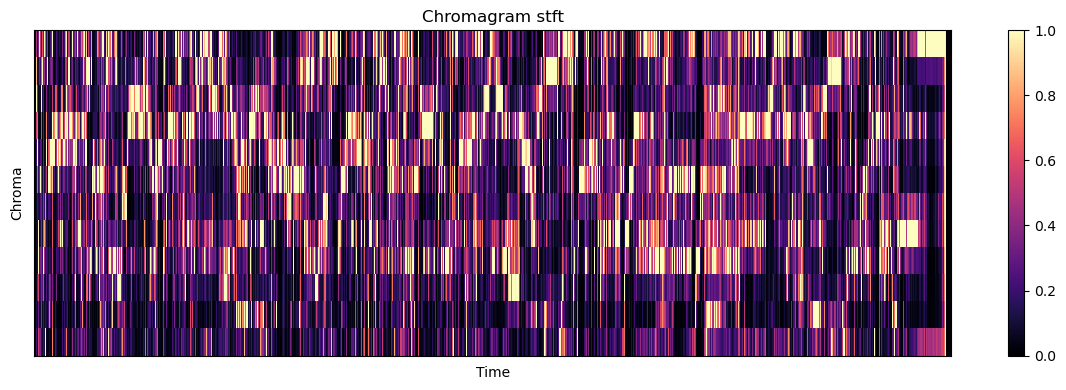

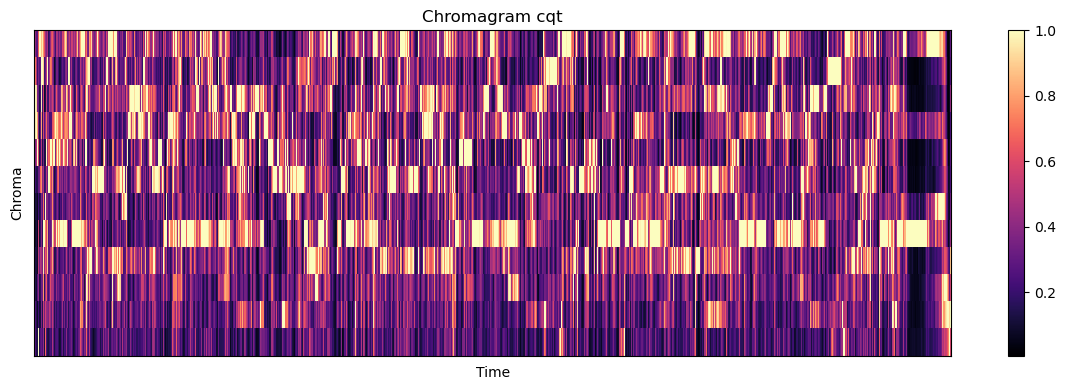

In [11]:
# Load audio file

fn_wav = os.path.join('data', 'audio', 'ElvisPresley_BlueChristmas.wav')
x, Fs = librosa.load(fn_wav)

# Load .csv file

ground_truth = os.path.join('data', 'ground_truth.xlsx')
truth = pd.read_excel(ground_truth, index_col=0)

# Print ground-truth key

print('\nThe ground-truth is', truth.at['Elvis Presley', 'Key'])

# Binary profiles for major and minor scales

template_cmaj = np.array([[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]]).T
template_cmin = np.array([[1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]]).T

# Perceptual profiles for major and minor scales

template_cmaj_perceptual = np.array([[6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]]).T
template_cmin_perceptual = np.array([[6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]]).T

# Compute chromagram

C = compute_chromagram(x, Fs, 'stft', True)

# Detect key

best_key_stft, best_corr_stft, alt_key_stft, alt_best_corr_stft = detect_key(C, template_cmaj, template_cmin, False)
best_key_stft_perceptual, best_corr_stft_perceptual, alt_key_stft_perceptual, alt_best_corr_stft_perceptual = detect_key(C, template_cmaj_perceptual, template_cmin_perceptual, False)

# Same thing for chroma_cqt
C = compute_chromagram(x, Fs, 'cqt', True)

best_key_cqt, best_corr_cqt, alt_key_cqt, alt_best_corr_cqt = detect_key(C, template_cmaj, template_cmin, False)
best_key_cqt_perceptual, best_corr_cqt_perceptual, alt_key_cqt_perceptual, alt_best_corr_cqt_perceptual = detect_key(C, template_cmaj_perceptual, template_cmin_perceptual, False)

# Print the key determined by the algorithm and the best alternative
print('\n\nBINARY PROFILES:')
print('\nstft')
print('Best_key =', best_key_stft, 'Best_corr =', best_corr_stft)
print('Alt_key =', alt_key_stft, 'Alt_best_corr =', alt_best_corr_stft)
print('\ncqt')
print('Best_key =', best_key_cqt, 'Best_corr =', best_corr_cqt)
print('Alt_key =', alt_key_cqt, 'Alt_best_corr =', alt_best_corr_cqt)

print('\n\nPERCEPTUAL PROFILES:')
print('\nstft')
print('Best_key =', best_key_stft_perceptual, 'Best_corr =', best_corr_stft_perceptual)
print('Alt_key =', alt_key_stft_perceptual, 'Alt_best_corr =', alt_best_corr_stft_perceptual)
print('\ncqt')
print('Best_key =', best_key_cqt_perceptual, 'Best_corr =', best_corr_cqt_perceptual)
print('Alt_key =', alt_key_cqt_perceptual, 'Alt_best_corr =', alt_best_corr_cqt_perceptual)